In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2024-06-03 09:28:35.809810: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 09:28:35.846680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 09:28:36.510711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a channel dimension (since the images are grayscale)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Print the shape of the data
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [3]:
# Encoder
def build_encoder():
    input_img = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    return tf.keras.models.Model(input_img, encoded, name='encoder')

# Decoder
def build_decoder():
    encoded_input = tf.keras.layers.Input(shape=(7, 7, 32))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_input)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return tf.keras.models.Model(encoded_input, decoded, name='decoder')


In [4]:

# Build the autoencoder
encoder = build_encoder()
decoder = build_decoder()
autoencoder_input = tf.keras.layers.Input(shape=(28, 28, 1))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = tf.keras.models.Model(autoencoder_input, decoded_img, name='autoencoder')

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Print the model summary
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 32)          5888      
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         15105     
                                                                 
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
_________________________________________________________________


2024-06-03 09:28:37.996513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 09:28:38.016662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 09:28:38.016847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
# Train the autoencoder
history = autoencoder.fit(x_train, x_train,
                          epochs=40,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Epoch 1/40


2024-06-03 09:28:39.418202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2024-06-03 09:28:40.599400: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7a40c4028d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-03 09:28:40.599432: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-06-03 09:28:40.602648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-03 09:28:40.704034: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 [==============================] - 11s 25ms/step - loss: 0.3413 - val_loss: 0.2902
Epoch 2/40
235/235 [==============================] - 3s 13ms/step - loss: 0.2817 - val_loss: 0.2792
Epoch 3/40
235/235 [==============================] - 3s 12ms/step - loss: 0.2745 - val_loss: 0.2743
Epoch 4/40
235/235 [==============================] - 3s 13ms/step - loss: 0.2709 - val_loss: 0.2717
Epoch 5/40
235/235 [==============================] - 3s 13ms/step - loss: 0.2687 - val_loss: 0.2697
Epoch 6/40
235/235 [==============================] - 3s 13ms/step - loss: 0.2670 - val_loss: 0.2680
Epoch 7/40
235/235 [==============================] - 3s 12ms/step - loss: 0.2655 - val_loss: 0.2670
Epoch 8/40
235/235 [==============================] - 3s 14ms/step - loss: 0.2644 - val_loss: 0.2660
Epoch 9/40
235/235 [==============================] - 3s 14ms/step - loss: 0.2635 - val_loss: 0.2650
Epoch 10/40
235/235 [==============================] - 3s 13ms/step - loss: 0.2627 - val_loss: 0.2643

313/313 [==============================] - 0s 607us/step


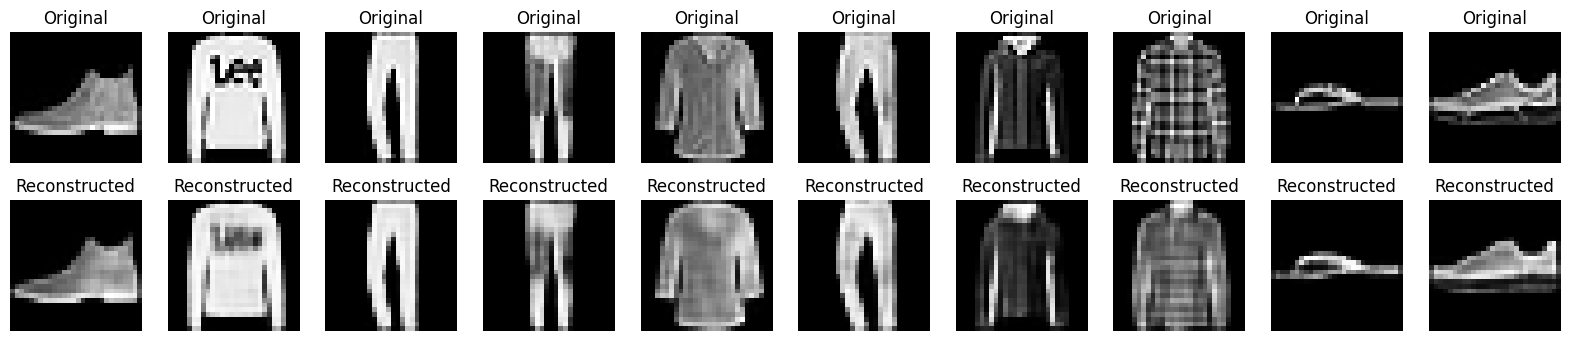

In [6]:
# Encode and decode some images
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Display the original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()


# Classification

In [7]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640

In [8]:
def global_avg_model():
    #val acc 85
    for layer in encoder.layers:
        layer.trainable = False

    input_img = tf.keras.layers.Input(shape=(28, 28, 1))
    x = encoder(input_img)
    x = tf.keras.layers.Conv2D(10, (3, 3), padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    logits = tf.keras.layers.GlobalAvgPool2D()(x)

    model = tf.keras.models.Model(input_img, logits, name='classifier')
    return model


def global_avg_model_with_dense():
    #val acc 70
    for layer in encoder.layers:
        layer.trainable = False

    input_img = tf.keras.layers.Input(shape=(28, 28, 1))
    x = encoder(input_img)
    # x = tf.keras.layers.Conv2D(10, (3, 3), padding='same')(x)
    # x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    logits = tf.keras.layers.Dense(10)(x)
    model = tf.keras.models.Model(input_img, logits, name='classifier')
    return model

def pure_cnn():
    # val acc 50%
    input_img = tf.keras.layers.Input(shape=(28, 28, 1))
    x = encoder(input_img)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(10, (4, 4), padding='valid', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    model = tf.keras.models.Model(input_img, x, name='classifier')
    return model


def pure_dense():
    # val acc 90%
    input_img = tf.keras.layers.Input(shape=(28, 28, 1))
    x = encoder(input_img)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.models.Model(input_img, x, name='classifier')
    return model


def pure_dense_deeper():
    # val acc 87%
    input_img = tf.keras.layers.Input(shape=(28, 28, 1))
    x = encoder(input_img)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.models.Model(input_img, x, name='classifier')
    return model



def pure_dense_unfreezed(n=3):
    # val acc 89%
    encoder.trainable = False
    for layer in encoder.layers[-n:]:
        layer.trainable = True
        
    input_img = tf.keras.layers.Input(shape=(28, 28, 1))
    x = encoder(input_img)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.models.Model(input_img, x, name='classifier')
    return model

model = pure_dense()


In [9]:

model.summary()


Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 32)          5888      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 10)                15690     
                                                                 
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [76]:
history = model.fit(x_train, y_train, epochs=30, 
                    validation_split=0.25)

Epoch 1/30
1407/1407 [==============================] - 2s 2ms/step - loss: 0.2673 - accuracy: 0.9021 - val_loss: 0.3016 - val_accuracy: 0.8923
Epoch 2/30
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2655 - accuracy: 0.9036 - val_loss: 0.2886 - val_accuracy: 0.8981
Epoch 3/30
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2629 - accuracy: 0.9046 - val_loss: 0.3049 - val_accuracy: 0.8904
Epoch 4/30
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2623 - accuracy: 0.9041 - val_loss: 0.2997 - val_accuracy: 0.8932
Epoch 5/30
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2625 - accuracy: 0.9035 - val_loss: 0.2972 - val_accuracy: 0.8916
Epoch 6/30
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2607 - accuracy: 0.9044 - val_loss: 0.3095 - val_accuracy: 0.8872
Epoch 7/30
1407/1407 [==============================] - 2s 2ms/step - loss: 0.2582 - accuracy: 0.9060 - val_loss: 0.2955 - val_accuracy: